In [1]:
import sys
sys.path.append('../')
from plotting import CandlePlot
import pandas as pd
import plotly.graph_objects as go

In [2]:
from technicals.patterns import apply_patterns

In [3]:
df = pd.read_pickle('../data/GBP_USD_M5.pkl')

In [4]:
df_analysis = df[['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c']].copy()

In [5]:
df_analysis.tail()

,time,mid_o,mid_h,mid_l,mid_c
626088,2024-05-31 20:35:00+00:00,1.27439,1.27442,1.27436,1.27441
626089,2024-05-31 20:40:00+00:00,1.27440,1.27443,1.27428,1.27430
626090,2024-05-31 20:45:00+00:00,1.27432,1.27440,1.27422,1.27431
626091,2024-05-31 20:50:00+00:00,1.27430,1.27436,1.27412,1.27424
626092,2024-05-31 20:55:00+00:00,1.27424,1.27433,1.27421,1.27422


In [ ]:
# direction = df_analysis['mid_c'] - df_analysis['mid_o']
# body_size = abs(direction)
# full_range = df_analysis['mid_h'] - df_analysis['mid_l']
# body_perc = (body_size / full_range) * 100
# body_lower = df_analysis[['mid_c', 'mid_o']].min(axis=1)
# body_upper = df_analysis[['mid_c', 'mid_o']].max(axis=1)
# body_bottom_perc = ((body_lower - df_analysis['mid_l']) / full_range) * 100
# body_top_perc = 100 - (((df_analysis['mid_h'] - body_upper) / full_range) * 100)

# direction = [1 if x >= 0 else -1 for x in direction]

In [ ]:
# df_analysis['body_lower'] = body_lower
# df_analysis['body_upper'] = body_upper
# df_analysis['body_bottom_perc'] = body_bottom_perc
# df_analysis['body_top_perc'] = body_top_perc
# df_analysis['body_perc'] = body_perc

In [6]:
df_analysis = apply_patterns(df_analysis)

In [12]:
# Single candlestick patterns
HANGING_MAN_BODY = 15.0
HANGING_MAN_HEIGHT = 75.0

SHOOTING_STAR_BODY = 15.0
SHOOTING_STAR_HEIGHT = 25.0 

SPINNING_TOP_BODY = 15.0
SPINNING_TOP_MIN = 40.0
SPINNING_TOP_MAX = 60.0

MARUBOZU_BODY = 98.5

# Dual candlestick patterns
ENGULFING_FACTOR = 1.1 # 10%

TWEEZER_BODY = 15.0
TWEEZER_HL = 0.01
TWEEZER_TOP_BODY = 40.0
TWEEZER_BOTTOM_BODY = 60.0

# Triple candlestick pattern
MORNING_STAR_PREV_BODY = 10.0
MORNING_STAR_PREV_2_BODY = 90.0


In [13]:
# Single candlestick patterns
def apply_hanging_man(row):
    if row['body_bottom_perc'] > HANGING_MAN_HEIGHT and row['body_perc'] < HANGING_MAN_BODY:
        return True

    return False

def apply_shooting_star(row):
    if row['body_top_perc'] < SHOOTING_STAR_HEIGHT and row['body_perc'] < SHOOTING_STAR_BODY:
        return True

    return False

def apply_spinning_top(row):
    if row['body_top_perc'] < SPINNING_TOP_MAX and row['body_bottom_perc'] > SPINNING_TOP_MIN and row['body_perc'] < SPINNING_TOP_BODY:
        return True

    return False

apply_marubozu = lambda x: x['body_perc'] > MARUBOZU_BODY


# Dual candlestick patterns
def apply_engulfing(row):
    if row['direction'] != row['direction_prev']:
        if row['body_size'] > row['body_size_prev'] * ENGULFING_FACTOR:
            return True

    return False

def apply_tweezer_top(row):
    if abs(row['body_size_change']) < TWEEZER_BODY:
        if row['direction'] == -1 and row['direction'] != row['direction_prev']:
            if abs(row['low_change']) < TWEEZER_HL and abs(row['high_change']) < TWEEZER_HL:
                if row['body_top_perc'] < TWEEZER_TOP_BODY:
                    return True

    return False

def apply_tweezer_bottom(row):
    if abs(row['body_size_change']) < TWEEZER_BODY:
        if row['direction'] == 1 and row['direction'] != row['direction_prev']:
            if abs(row['low_change']) < TWEEZER_HL and abs(row['high_change']) < TWEEZER_HL:
                if row['body_bottom_perc'] > TWEEZER_BOTTOM_BODY:
                    return True

    return False


# Triple candlestick pattern
def apply_morning_star(row, direction=1):
    if row['body_perc_prev_2'] > MORNING_STAR_PREV_2_BODY:
        if row['body_perc_prev'] < MORNING_STAR_PREV_BODY:
            if row['direction'] == direction and row['direction_prev_2'] != direction:
                if direction == 1:
                    if row['mid_c'] > row['mid_point_prev_2']:
                        return True
                else:
                    if row['mid_c'] < row['mid_point_prev_2']:
                        return True

    return False
                        


In [14]:
df_analysis['body_size_prev'] = df_analysis['body_size'].shift(1)

df_analysis['direction_prev'] = df_analysis['direction'].shift(1)
df_analysis['direction_prev_2'] = df_analysis['direction'].shift(2)

df_analysis['body_perc_prev'] = df_analysis['body_perc'].shift(1)
df_analysis['body_perc_prev_2'] = df_analysis['body_perc'].shift(2)

# Single candlestick patterns
df_analysis['hanging_man'] = df_analysis.apply(apply_hanging_man, axis=1)
df_analysis['shooting_star'] = df_analysis.apply(apply_shooting_star, axis=1)
df_analysis['spinning_top'] = df_analysis.apply(apply_spinning_top, axis=1)
df_analysis['marubozu'] = df_analysis.apply(apply_marubozu, axis=1)

# Dual candlestick patterns
df_analysis['engulfing'] = df_analysis.apply(apply_engulfing, axis=1)
df_analysis['tweezer_top'] = df_analysis.apply(apply_tweezer_top, axis=1)
df_analysis['tweezer_bottom'] = df_analysis.apply(apply_tweezer_bottom, axis=1)

# Triple candlestick patterns
df_analysis['morning_star'] = df_analysis.apply(apply_morning_star, axis=1)
df_analysis['evening_star'] = df_analysis.apply(apply_morning_star, axis=1, direction=-1)


In [16]:
MARKER_HANGING_MAN = '#0066FF'
MARKER_SHOOTING_STAR = '#FFA500'
MARKER_SPINNING_TOP = '#FFFF00'
MARKER_MARUBOZU = '#FFFFFF'
MARKER_ENGULFING = '#FFC0CB'
MARKER_TWEEZER_TOP = '#9ACD32'
MARKER_TWEEZER_BOTTOM = '#D4AF37'
MARKER_MORNING_STAR = '#87CEEB'
MARKER_EVENING_STAR = '#800080'

In [24]:
df_plot = df_analysis.iloc[622100:622700]

In [25]:
def add_trace(df, marker, name):
    cp.fig.add_trace(go.Candlestick(
        x=df['s_time'],
        open=df['mid_o'],
        high=df['mid_h'],
        low=df['mid_l'],
        close=df['mid_c'],
        line={'width': 1},
        opacity=1,
        increasing_fillcolor=marker,
        decreasing_fillcolor=marker ,
        increasing_line_color=marker,
        decreasing_line_color=marker,
        name=name
    ))

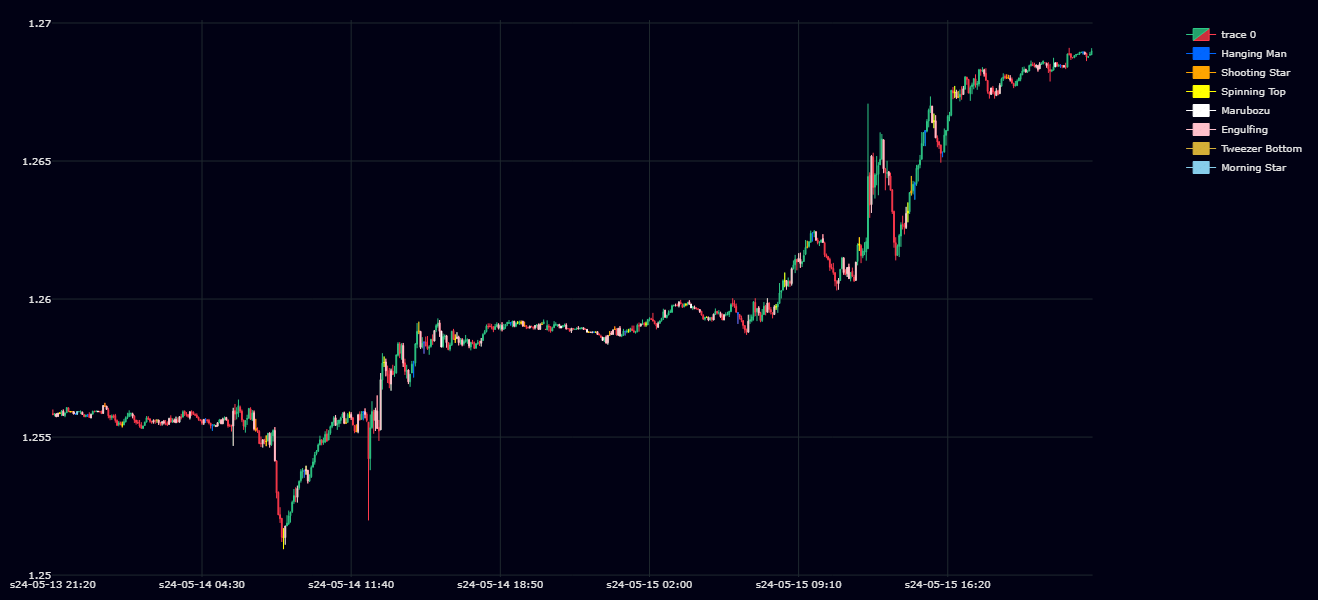

In [26]:
cp = CandlePlot(df_plot, candles=True)
df_hanging_man = cp.df_plot[cp.df_plot['hanging_man'] == True]
df_shooting_star = cp.df_plot[cp.df_plot['shooting_star'] == True]
df_spinning_top = cp.df_plot[cp.df_plot['spinning_top'] == True]
df_marubozu = cp.df_plot[cp.df_plot['marubozu'] == True]
df_engulfing = cp.df_plot[cp.df_plot['engulfing'] == True]
df_tweezer_top = cp.df_plot[cp.df_plot['tweezer_top'] == True]
df_tweezer_bottom = cp.df_plot[cp.df_plot['tweezer_bottom'] == True]
df_morning_star = cp.df_plot[cp.df_plot['morning_star'] == True]
df_evening_star = cp.df_plot[cp.df_plot['evening_star'] == True]

add_trace(df_hanging_man, MARKER_HANGING_MAN, 'Hanging Man')
add_trace(df_shooting_star, MARKER_SHOOTING_STAR, 'Shooting Star')
add_trace(df_spinning_top, MARKER_SPINNING_TOP, 'Spinning Top')
add_trace(df_marubozu, MARKER_MARUBOZU, 'Marubozu')
add_trace(df_engulfing, MARKER_ENGULFING, 'Engulfing')
add_trace(df_tweezer_top, MARKER_TWEEZER_TOP, 'Tweezer Top')
add_trace(df_tweezer_bottom, MARKER_TWEEZER_BOTTOM, 'Tweezer Bottom')
add_trace(df_morning_star, MARKER_MORNING_STAR, 'Morning Star')
add_trace(df_evening_star, MARKER_EVENING_STAR, 'Evening Star')

cp.show_plot()